Cell 1: Imports and Setup


In [45]:
!pip install tensorflow opencv-python

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from zipfile import ZipFile
import cv2

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Cell 2: Mount Drive and Extract Zip



In [46]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Dataset/PokemonData.zip'
extracted_dir = '/content/PokemonData'

if not os.path.exists(extracted_dir):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print(f"Extracted {zip_path} to {extracted_dir}")
else:
    print(f"Directory {extracted_dir} already exists. Skipping extraction.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory /content/PokemonData already exists. Skipping extraction.





Cell 3: Load Pre-trained Model




In [47]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze initially

Cell 4: Create Classifier




In [48]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(151, activation='softmax')(x)

model = keras.Model(inputs, outputs)




Cell 5: Compile the Model




In [49]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

Cell 6: Data Augmentation




In [50]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

Cell 7: Data Preprocessing Function




In [51]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label



Cell 8: Data Loading (from extracted directory)




In [52]:
dataset_path = '/content/PokemonData/PokemonData'


try:
    # 1. Create a dataset for getting class names (with shuffle=False)
    temp_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(256, 256),
        batch_size=32,
        shuffle=False  # Crucial for consistent class names
    )
    class_names = temp_ds.class_names
    del temp_ds

    # 2. Now create the TRAINING dataset (with validation_split and subset)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(256, 256),
        batch_size=32,
        validation_split=0.2,
        subset="training",
        seed=42
    ).map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

    # 3. Create the VALIDATION dataset (with validation_split and subset)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels='inferred',
        label_mode='categorical',
        image_size=(256, 256),
        batch_size=32,
        validation_split=0.2,
        subset="validation",
        seed=42
    ).map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

    # 4. Check and reshape if labels are not one-hot encoded (Important!)
    for images, labels in train_ds.take(1):
        if labels.shape[-1] != 151:  # Check if last dimension is not 151
            print("Reshaping labels to one-hot encoding...")
            train_ds = train_ds.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=151)))
            val_ds = val_ds.map(lambda x, y: (x, tf.keras.utils.to_categorical(y, num_classes=151)))
            break

except FileNotFoundError:
    print(f"Error: Dataset not found at {dataset_path}. Check your path in Google Drive and extraction directory.")
    exit()

for images, labels in train_ds.take(1):
    print("Training Images:", images.shape, "Training Labels:", labels.shape)

for images, labels in val_ds.take(1):
    print("Validation Images:", images.shape, "Validation Labels:", labels.shape)


Found 11945 files belonging to 151 classes.
Found 11945 files belonging to 151 classes.
Using 9556 files for training.
Found 11945 files belonging to 151 classes.
Using 2389 files for validation.
Training Images: (32, 224, 224, 3) Training Labels: (32, 151)
Validation Images: (32, 224, 224, 3) Validation Labels: (32, 151)


Cell 9: Visualize Images (Optional)




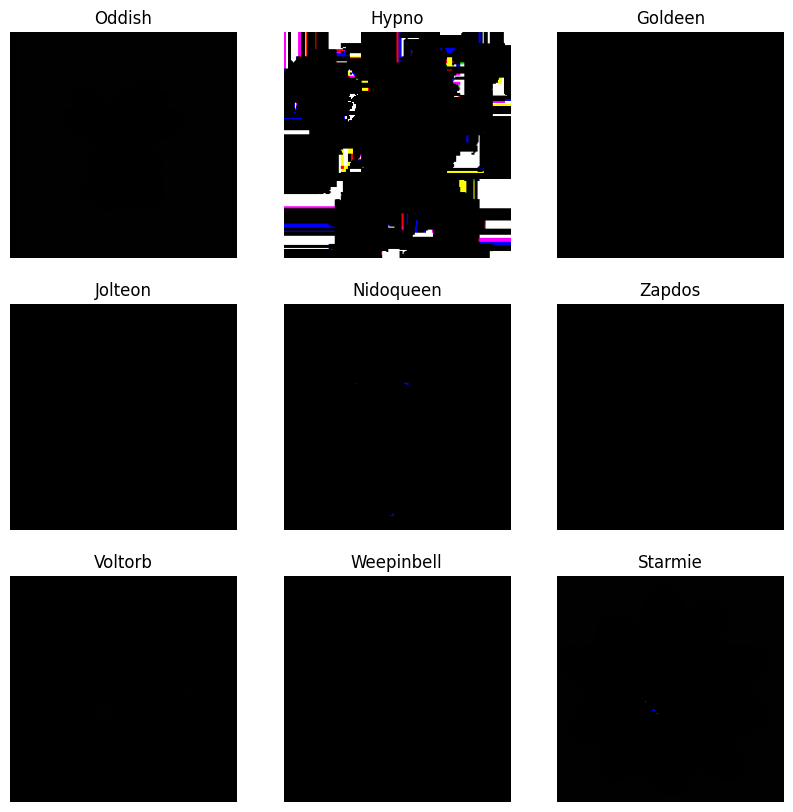

In [53]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()


Cell 10: Train with Frozen Base (with Early Stopping)





In [54]:
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 34s 78ms/step - accuracy: 0.0676 - loss: 4.6675 - val_accuracy: 0.4383 - val_loss: 2.6174
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4297 - loss: 2.3773 - val_accuracy: 0.5956 - val_loss: 1.6886
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6203 - loss: 1.5152 - val_accuracy: 0.6505 - val_loss: 1.3974
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.6870 - loss: 1.1743 - val_accuracy: 0.6697 - val_loss: 1.2871
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.7493 - loss: 0.9385 - val_accuracy: 0.6735 - val_loss: 1.2500
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7917 - loss: 0.7771 - val_accuracy: 0.6902 - val_loss: 1.1721
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8168 - loss: 0.6747 - val_accuracy: 0.7053 - val_loss: 1.1500
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8444 - loss: 0.5659 - 

Cell 11: Unfreeze and Fine-tune (with Early Stopping)




In [55]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

fine_tune_epochs = 50
total_epochs = epochs + fine_tune_epochs
early_stopping_fine = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[early_stopping_fine])

Epoch 15/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.5786 - loss: 1.5595 - val_accuracy: 0.7233 - val_loss: 1.0693
Epoch 16/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.7422 - loss: 0.9129 - val_accuracy: 0.7313 - val_loss: 1.0249
Epoch 17/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8109 - loss: 0.6619 - val_accuracy: 0.7401 - val_loss: 0.9892
Epoch 18/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8512 - loss: 0.5339 - val_accuracy: 0.7505 - val_loss: 0.9601
Epoch 19/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8708 - loss: 0.4475 - val_accuracy: 0.7593 - val_loss: 0.9350
Epoch 20/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9051 - loss: 0.3498 - val_accuracy: 0.7639 - val_loss: 0.9150
Epoch 21/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9216 - loss: 0.3017 - val_accuracy: 0.7656 - val_loss: 0.8987
Epoch 22/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9333 -

Cell 12: Convert to TFLite




In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('pokemon_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpuwrxapd_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_474')
Output Type:
  TensorSpec(shape=(None, 151), dtype=tf.float32, name=None)
Captures:
  138453281969552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934180560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934168240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934166128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934172640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138453238144464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934179504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138452934169648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138455203890096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138455203898192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13845293

Cell 13: Plot Training History


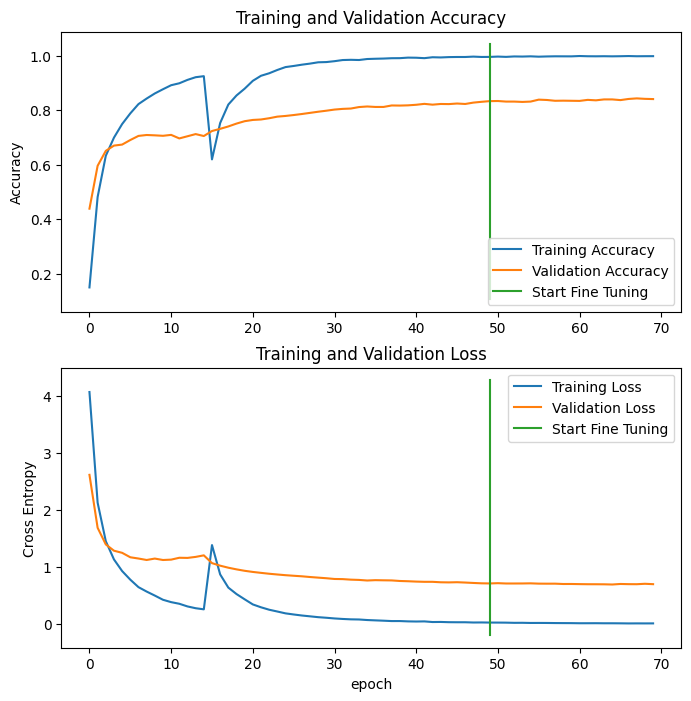

In [57]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([epochs-1, epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([epochs-1, epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()